### Setup

In [23]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Subset
from tqdm import tqdm
import os
import random
from PIL import Image

In [24]:
# Set random seed for reproducibility
SEED = 2024
torch.manual_seed(SEED)
np.random.seed(SEED)

In [25]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("CUDA is available! GPU can be used.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available! GPU can be used.
Device name: NVIDIA GeForce RTX 3050 Laptop GPU


### Load Data

In [26]:
# Data directory
TRAIN_DIR = './data/enemel/animals/train'
TEST_DIR = './data/enemel/animals/val'

In [27]:
# Loading parameters
BATCH_SIZE = 64
IMG_SIZE = 256
VAL_SPLIT = 0.2

### Train, Validasi, dan Test Split

In [28]:
# Data augmentation and normalization for training and validation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [29]:
# Load the dataset and split into training and validation
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
class_names = train_dataset.classes
num_classes = len(class_names)

In [30]:
# Split dataset
val_size = int(VAL_SPLIT * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [31]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [32]:
# Load test dataset
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Visualisasi Data

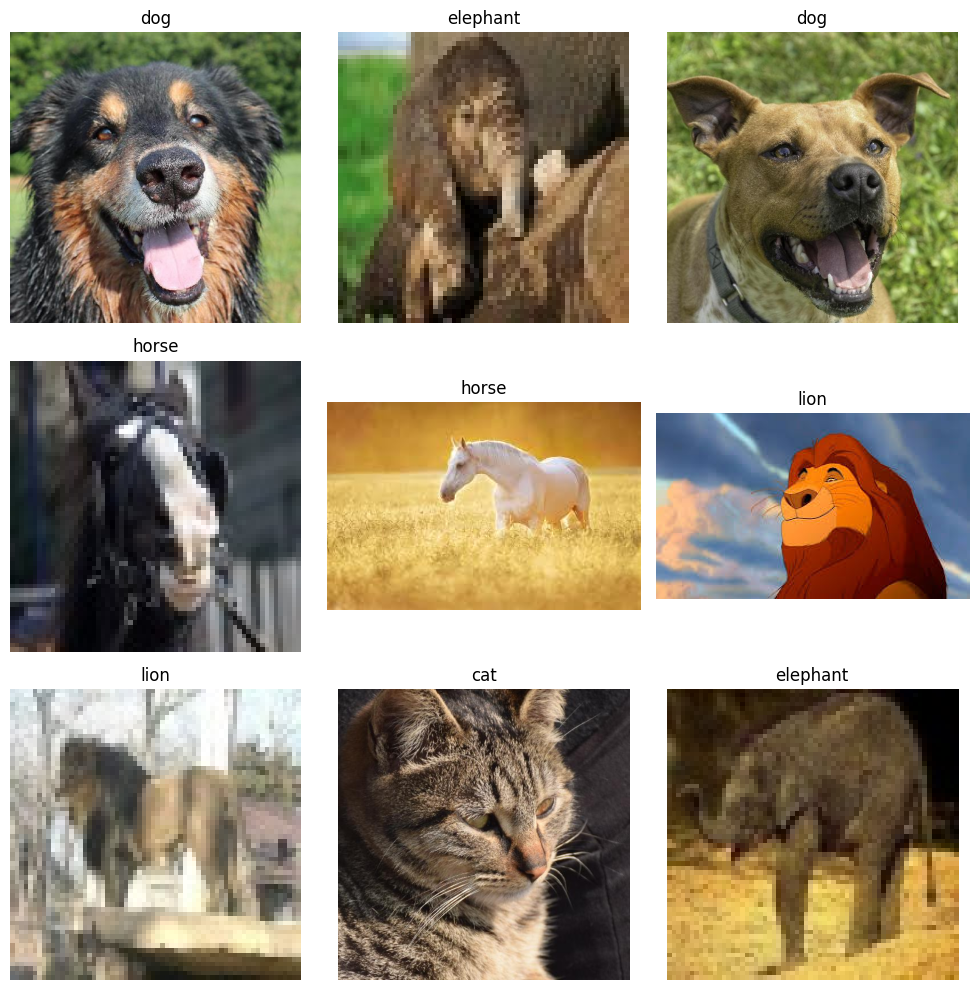

In [18]:
# Number of images to display
num_images = 9

# Create a figure
plt.figure(figsize=(10, 10))

# Randomly select images
for i in range(num_images):
    # Select a random class
    class_name = random.choice(class_names)
    
    # Get a random image path from the selected class
    class_dir = os.path.join(TRAIN_DIR, class_name)
    image_path = random.choice(os.listdir(class_dir))
    image = Image.open(os.path.join(class_dir, image_path))
    
    # Plot the image
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(image)
    plt.title(class_name)
    plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()

### Model

In [33]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

cnn_model = CNNModel(num_classes).to(device)

In [15]:
# Define optimizer, loss function, and early stopping criteria
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

In [16]:
# Training parameters
PATIENCE = 10
EPOCHS = 200
best_val_acc = 0
no_improvement_count = 0

### Train Model

In [16]:
# Training and validation loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for epoch in range(EPOCHS):
    cnn_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    cnn_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Check for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improvement_count = 0
        torch.save(cnn_model.state_dict(), "best_model.pth")
    else:
        no_improvement_count += 1
    
    if no_improvement_count >= PATIENCE:
        print("Early stopping")
        break

# Load the best model for evaluation
cnn_model.load_state_dict(torch.load("best_model.pth"))

  0%|          | 0/169 [00:00<?, ?it/s]

100%|██████████| 169/169 [00:42<00:00,  3.96it/s]


Early stopping


<All keys matched successfully>

### Visualisasi Hasil Training

In [34]:
# Load the best model for evaluation
cnn_model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [35]:
# Evaluation on test data
test_labels = []
predicted_labels = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.append(labels.cpu().item())
        predicted_labels.append(predicted.cpu().item())

In [ ]:
# Plotting accuracy and loss curves
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

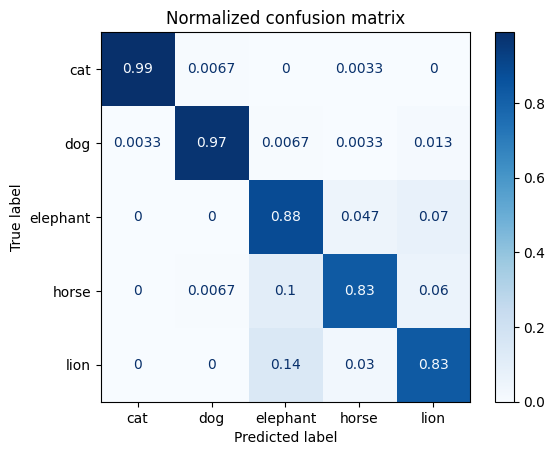

In [20]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    test_labels, predicted_labels,
    display_labels=class_names,
    cmap=plt.cm.Blues,
    normalize='true')

disp.ax_.set_title('Normalized confusion matrix')
plt.show()

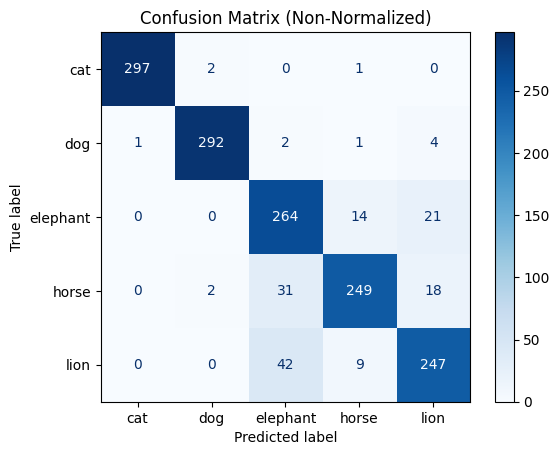

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix without normalization
cm = confusion_matrix(test_labels, predicted_labels)

# Display the non-normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Non-Normalized)')
plt.show()

In [ ]:
torch.save(cnn_model.state_dict(), "best_model.pth")